<a href="https://colab.research.google.com/github/rdgreene/CNN-Workshop/blob/master/CNN_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title <--- Run this to download data an initialise your environment
%%capture

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
plt.style.use('ggplot')

!git clone https://ronangreene@bitbucket.org/ronangreene/cats_vs_dogs.git # clone repository with cats and dogs images
!unzip cats_vs_dogs/data.zip # unzip data in clones repo
!rm -r cats_vs_dogs # remove zipped data

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'



### Intro to Keras
Keras is a Python package for deep learning package that cuts through a lot of the nitty gritty of programming deep learning models. There are a few different ways to use keras, but we will be using it to make sequential models, where we add layers to the model one at a time. You can find all of the keras documentation [here](https://keras.io/). We start importanting the various Keras sub-packages that we need for todays workshop, and process to define a CNN model as a sequence of convolutional, maxpooling, and dense layers. Once this is done the model is compiled for use.

In [0]:
# import required Keras sub-packages
%tensorflow_version 2.x
#import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

TensorFlow 2.x selected.


'2.2.4-tf'

In [0]:
# this defines the input size of the images we will be feeding into our model
target_size = 64

model = models.Sequential()

# first block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# second block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# third block of convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# final dense layer for classification
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile model ready for use
model.compile(
    loss='binary_crossentropy', # determines how errors are measured
    optimizer='adam', # determines gradient descent algorithm used
    metrics=['accuracy'] # metric used to monitor model performance during training
    )

# prints out a summary of the compiled model
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 2304)            

Next we want to use Keras' ImageDataGenerator object to feeding image data into own CNN direct from the image directory. We set up flows from two seperate directories, one containing training images, and the other containing validation images. The training images are used for directly training the model, while that validation images are used to evaluate how well the trained model generalises to images it did not see during training!

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255) # TODO: move

# flow for training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

# flow for validation images
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [0]:
import time

Once the model is compiled we can begin training the model. During this process the training images are fed through the model in batches, with the model predicting the class of each image in the batch. After processing a batch, the weights in the network are updated by backpropogating the prediction errors from that particular batch. This occurs for a total of 40 epochs, where one epoch is defined as a single pass over all the images in the training dataset. Throughout this whole process, the validation images are used to evaluate how well the model is doing at classifying images that it has not been exposed to during training. 

Note: It is usual to observe that the accuracy of the model when classifying validation images is less than that when classifying training images.

In [0]:
tic = time.time()

history = model.fit_generator(
      train_generator,
      epochs=40,
      validation_data=validation_generator,
  )

toc = time.time()
print((toc-tic)/60)

Epoch 1/20
50/50 [==============================] - 16s 315ms/step - loss: 0.6972 - accuracy: 0.4969 - val_loss: 0.7126 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 16s 312ms/step - loss: 0.6912 - accuracy: 0.5369 - val_loss: 0.6912 - val_accuracy: 0.5700
Epoch 3/20
50/50 [==============================] - 15s 307ms/step - loss: 0.6795 - accuracy: 0.5894 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 15s 308ms/step - loss: 0.6709 - accuracy: 0.5981 - val_loss: 0.6523 - val_accuracy: 0.5800
Epoch 5/20
50/50 [==============================] - 15s 299ms/step - loss: 0.6233 - accuracy: 0.6394 - val_loss: 0.6087 - val_accuracy: 0.6500
Epoch 6/20
50/50 [==============================] - 15s 307ms/step - loss: 0.5659 - accuracy: 0.7119 - val_loss: 0.6377 - val_accuracy: 0.6700
Epoch 7/20
50/50 [==============================] - 15s 309ms/step - loss: 0.5484 - accuracy: 0.7181 - val_loss: 0.6110 - val_accuracy: 0.6250

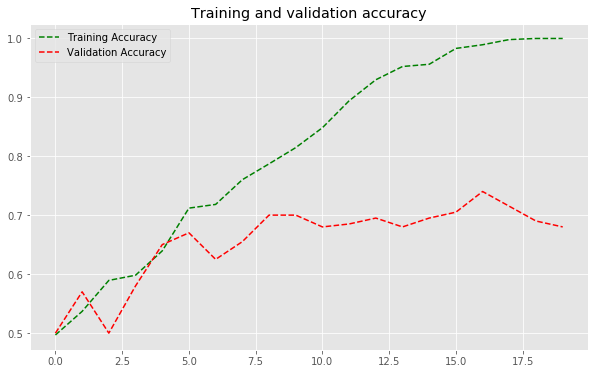

In [0]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(train_accuracy))

plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

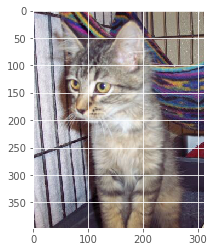

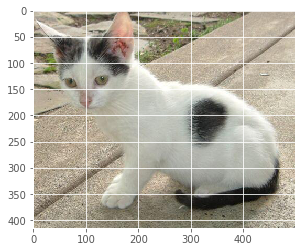

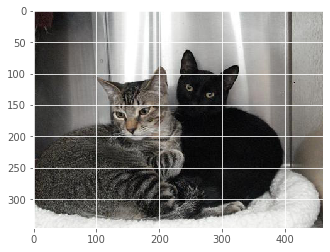

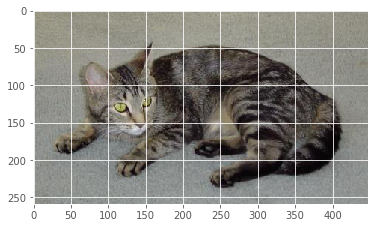

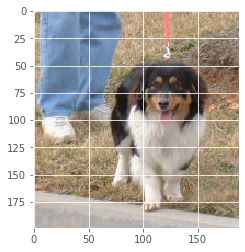

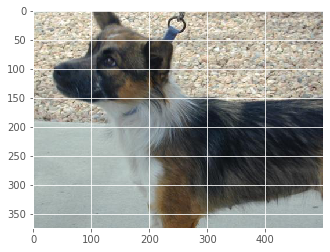

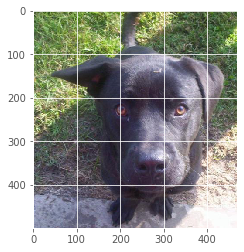

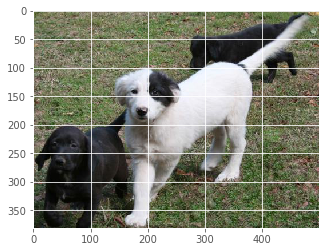

In [0]:
#@title A sample of our data! { vertical-output: true }
for animal in ['cats', 'dogs']:
  for i in ['2', '3', '8', '16']:
    plt.figure()
    plt.imshow(image.load_img(f'data/train/{animal}/{i}.jpg'))

In [0]:
# adding droput and image augmentation

aug_train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

aug_train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

Found 1600 images belonging to 2 classes.


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 2304)            

In [0]:
tic = time.time()

history = model.fit_generator(
      aug_train_generator,
      epochs=20,
      validation_data=validation_generator,
  )

toc = time.time()
print((toc-tic)/60)

Epoch 1/20
50/50 [==============================] - 16s 322ms/step - loss: 0.6907 - accuracy: 0.5375 - val_loss: 0.6790 - val_accuracy: 0.5250
Epoch 2/20
50/50 [==============================] - 15s 305ms/step - loss: 0.6747 - accuracy: 0.5744 - val_loss: 0.6662 - val_accuracy: 0.5800
Epoch 3/20
50/50 [==============================] - 15s 303ms/step - loss: 0.6149 - accuracy: 0.6700 - val_loss: 0.6183 - val_accuracy: 0.6950
Epoch 4/20
50/50 [==============================] - 16s 312ms/step - loss: 0.5843 - accuracy: 0.6819 - val_loss: 0.5748 - val_accuracy: 0.7000
Epoch 5/20
50/50 [==============================] - 16s 314ms/step - loss: 0.5262 - accuracy: 0.7444 - val_loss: 0.5632 - val_accuracy: 0.7250
Epoch 6/20
50/50 [==============================] - 15s 309ms/step - loss: 0.4837 - accuracy: 0.7688 - val_loss: 0.5287 - val_accuracy: 0.7450
Epoch 7/20
50/50 [==============================] - 16s 310ms/step - loss: 0.4643 - accuracy: 0.7794 - val_loss: 0.5245 - val_accuracy: 0.7000

In [0]:
len(history.history['accuracy'])

40

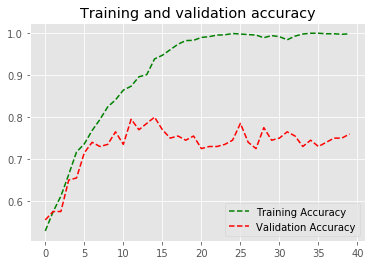

In [0]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(train_accuracy))

#plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### DEV AREA

In [0]:
import time
time.time()

1572782293.2272391

In [0]:

ls

cats_test  cats_train  cats_val  dogs_test  dogs_train	dogs_val


In [0]:
from skimage import io, transform
import numpy as np
import time

tic = time.time()

data = []
test_data = []

# get train and test data for cats
# for i, file in enumerate(cats):
#     try:
#         myimage = io.imread('data/cats/' + file).astype(np.float32)/255
#         myimage = transform.resize(myimage, (64, 64, 3))
#         if i < 950:
#           data.append((myimage, 1))
#         else:
#           test_data.append((myimage, 1))
#     except:
#         pass

# get train and test data for dogs
for i, file in enumerate(dogs):
    try:
        myimage = io.imread('data/dogs/' + file).astype(np.float32)/255
        myimage = transform.resize(myimage, (64, 64, 3))
        if i < 950:
          data.append((myimage, 1))
        else:
          test_data.append((myimage, 1))
    except:
        pass

print(time.time() - tic)



In [0]:
# build neural network

from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

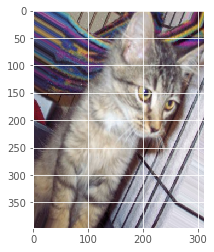

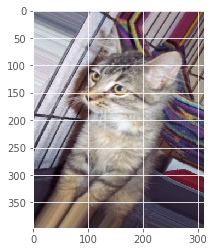

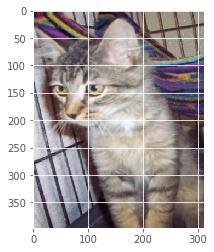

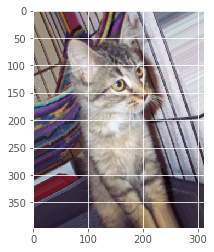

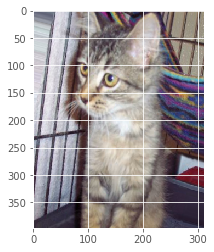

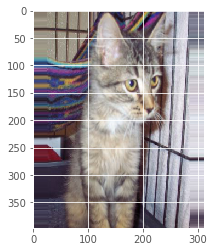

In [0]:
datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

img = image.load_img('data/train/cats/2.jpg')
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    if i > 4:
        break

plt.show()